# Surviving the Titanic: KNN Classification of Passenger Survival



**Introduction:** 

On April 14th, 1912, the Titanic, which was the most advanced ship at the time, hit an iceberg and sank (History.com). Though it had 16 lifeboats, which could hold a maximum of 1178 people, out of the 2208 passengers on board, only 705 survived (Barrratt 2009). There were three classes and three different resulting fare values for the First, Second, and Third classes. The third class made up the majority of the passengers with 709 people, but when the Titanic sank, three-quarters of them died compared to those in First and Second Class (Person 2011). Therefore, our question is given the passenger's age and fare value, can we determine if they would have survived or not? Additionally to age and fare value, we also explore the relationship the sex of the passengers had on survival. The dataset we will be using is a tabular data set with comma-separated variables. It has ten variables, but out of the ten, we will be using four; Survived, Sex, Age, and Fare to answer our question.


**Preliminary exploratory data analysis:**

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(forcats)
library(broom)
options(repr.matrix.max.rows = 6)
train <- read_csv("train.csv") %>% mutate(Survived = as_factor(Survived)) %>%  drop_na(-Cabin)
summary(train)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

  PassengerId    Survived     Pclass         Name               Sex           
 Min.   :  1.0   0:424    Min.   :1.00   Length:712         Length:712        
 1st Qu.:222.8   1:288    1st Qu.:1.00   Class :character   Class :character  
 Median :445.0            Median :2.00   Mode  :character   Mode  :character  
 Mean   :448.6            Mean   :2.24                                        
 3rd Qu.:677.2            3rd Qu.:3.00                                        
 Max.   :891.0            Max.   :3.00                                        
      Age            SibSp           Parch           Ticket         
 Min.   : 0.42   Min.   :0.000   Min.   :0.0000   Length:712        
 1st Qu.:20.00   1st Qu.:0.000   1st Qu.:0.0000   Class :character  
 Median :28.00   Median :0.000   Median :0.0000   Mode  :character  
 Mean   :29.64   Mean   :0.514   Mean   :0.4326                     
 3rd Qu.:38.00   3rd Qu.:1.000   3rd Qu.:1.0000                     
 Max.   :80.00   Max.   :5.000   

The dataset uses the following columns:
<ul>
    <li><em>"PassengerId"</em>: Unique identifier for passengers</li>
    <li><em>"Survived"</em>: Class we are trying to predict, 1=Survived, 2=Passed</li>
    <li><em>"Sex"</em>: Male or Female</li>
    <li><em>"Age"</em>: Age in years(Predictor 1)</li>
    <li><em>"SibSp"</em>: Number of siblings / spouses aboard</li>
    <li><em>"Parch"</em>: Number of parents / children aboard</li>
    <li><em>"Ticket"</em>: Ticket number</li>
    <li><em>"Fare"</em>: Passenger fare (Predictor 2)</li>
    <li><em>"Cabin"</em>: Cabin number</li>
    <li><em>"Embarked"</em>: Port of Embarkation(C = Cherbourg, Q = Queenstown, S = Southampton)</li>
    <li><em>"DirectRelatives"</em>: SibSp + Parch</li>
</ul>

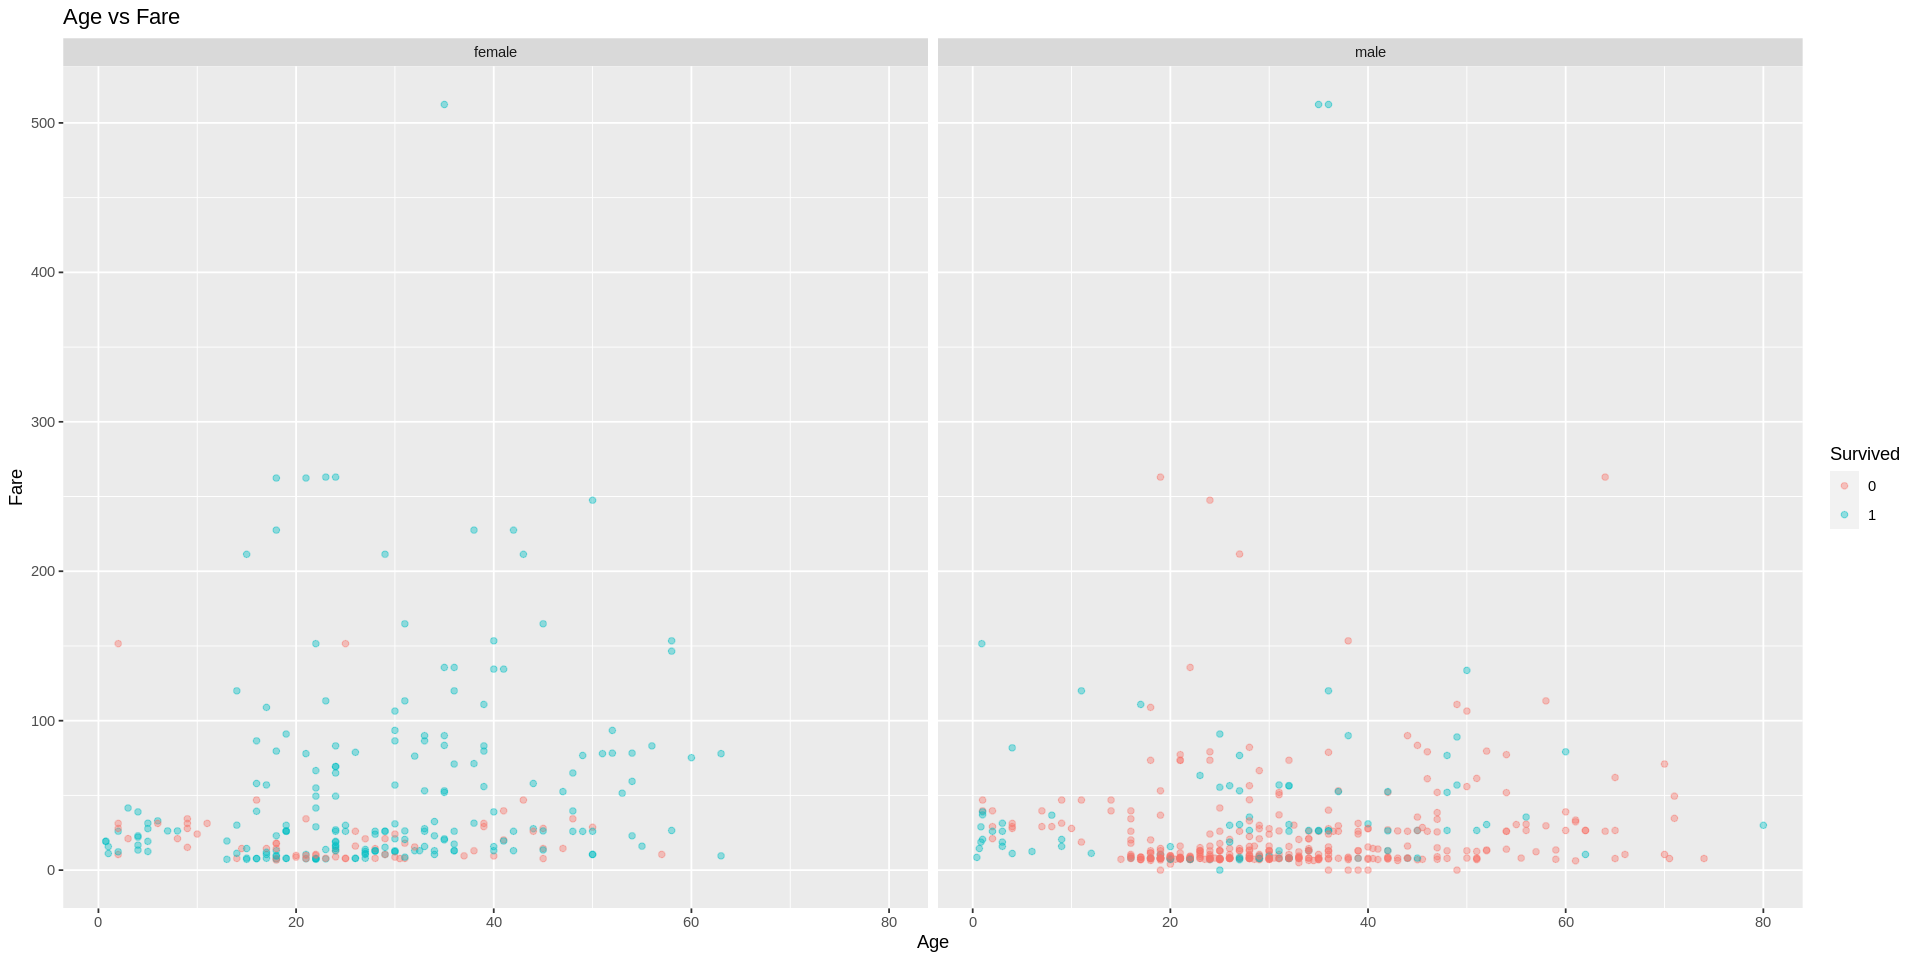

In [2]:
options(repr.plot.width = 16, repr.plot.height = 8) 
train %>% ggplot(aes(x = Age, y =  Fare, colour=Survived)) + 
           geom_point(alpha = 0.4) +
           xlab("Age") +
           ylab("Fare") +
           ggtitle("Age vs Fare") + facet_grid(. ~ Sex)

**Methods**: 

We used a knn classification to attempt to predict whether a passenger survived using Age and Fare as predictors. It was done to confirm or reject the popular 'myth' of how the lower classes were more vulnerable to perish after the crash. The two datasets we used were "train.csv" and "test.csv". The "train.csv" contains all columns described in the above section, but the "test.csv" includes every column except 'Survived'. Therefore, we decided to use the "train.csv" to obtain a trained classifier and to predict Survived for all the rows in the "test.csv." Additionally, cross-validation would be used to tune the classifier to the best 'K' value for the number of neighbors. This means that a part of the training data will be used to evaluate the classifier's accuracy for cross-validation rather than to train it.

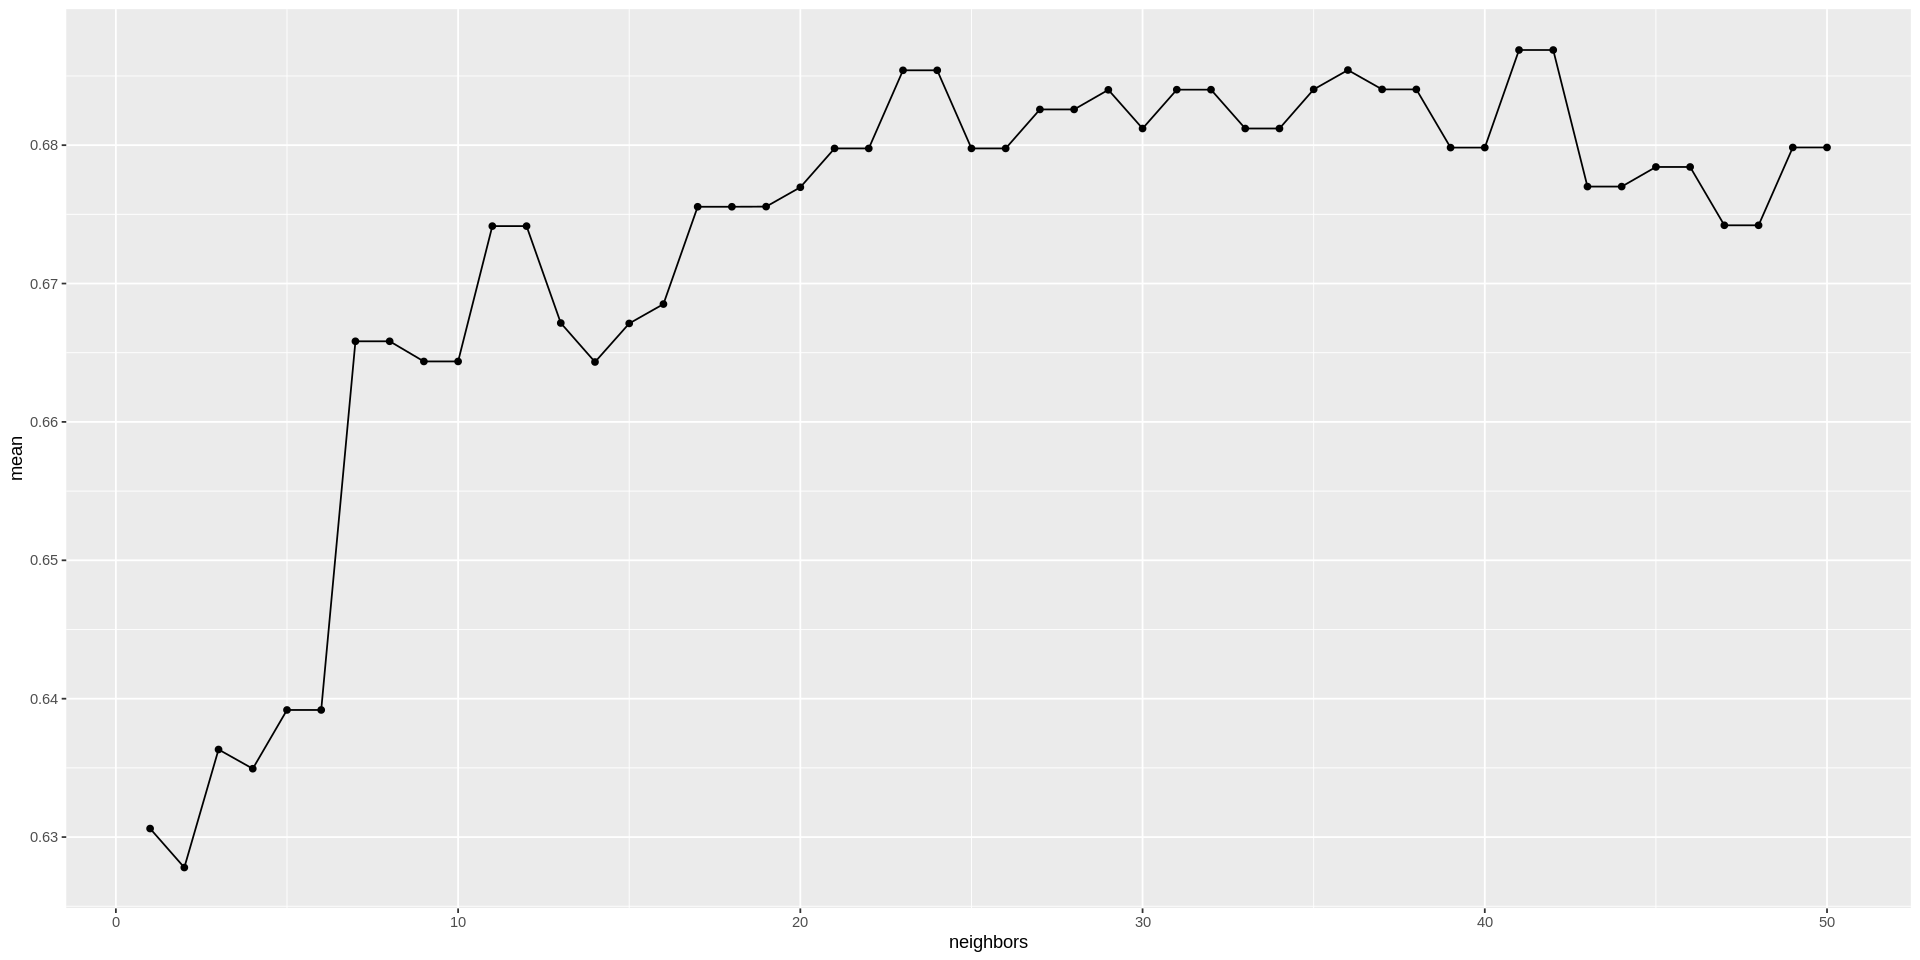

In [4]:
set.seed(2020) # DO NOT REMOVE

recipe <- recipe(Survived ~ Age + Fare , data = train) %>%
   step_scale(all_predictors()) %>%
    step_center(all_predictors())
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
the_vfold <- vfold_cv(train, v = 5, strata = Survived)

k_vals <- tibble(neighbors = seq(from = 1, to = 50))
results <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = the_vfold, grid = k_vals) %>%
      collect_metrics()
results %>% filter(.metric == "accuracy") %>%
                ggplot(aes(x=neighbors, y=mean))+ geom_point() + geom_line()


In [5]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 41) %>%
      set_engine("kknn") %>%
      set_mode("classification")
best_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(best_spec) %>%
        fit(data=train)
test <- read_csv("test.csv") %>%  drop_na(-Cabin)
predictions <- predict(best_fit,test) %>% bind_cols(test)

neighbors <- results %>% filter(.metric == "accuracy") %>%
    filter(mean == max(mean)) %>%
    head(1)
neighbors

Parsed with column specification:
cols(
  PassengerId = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,accuracy,binary,0.6868747,5,0.0121589,Model41


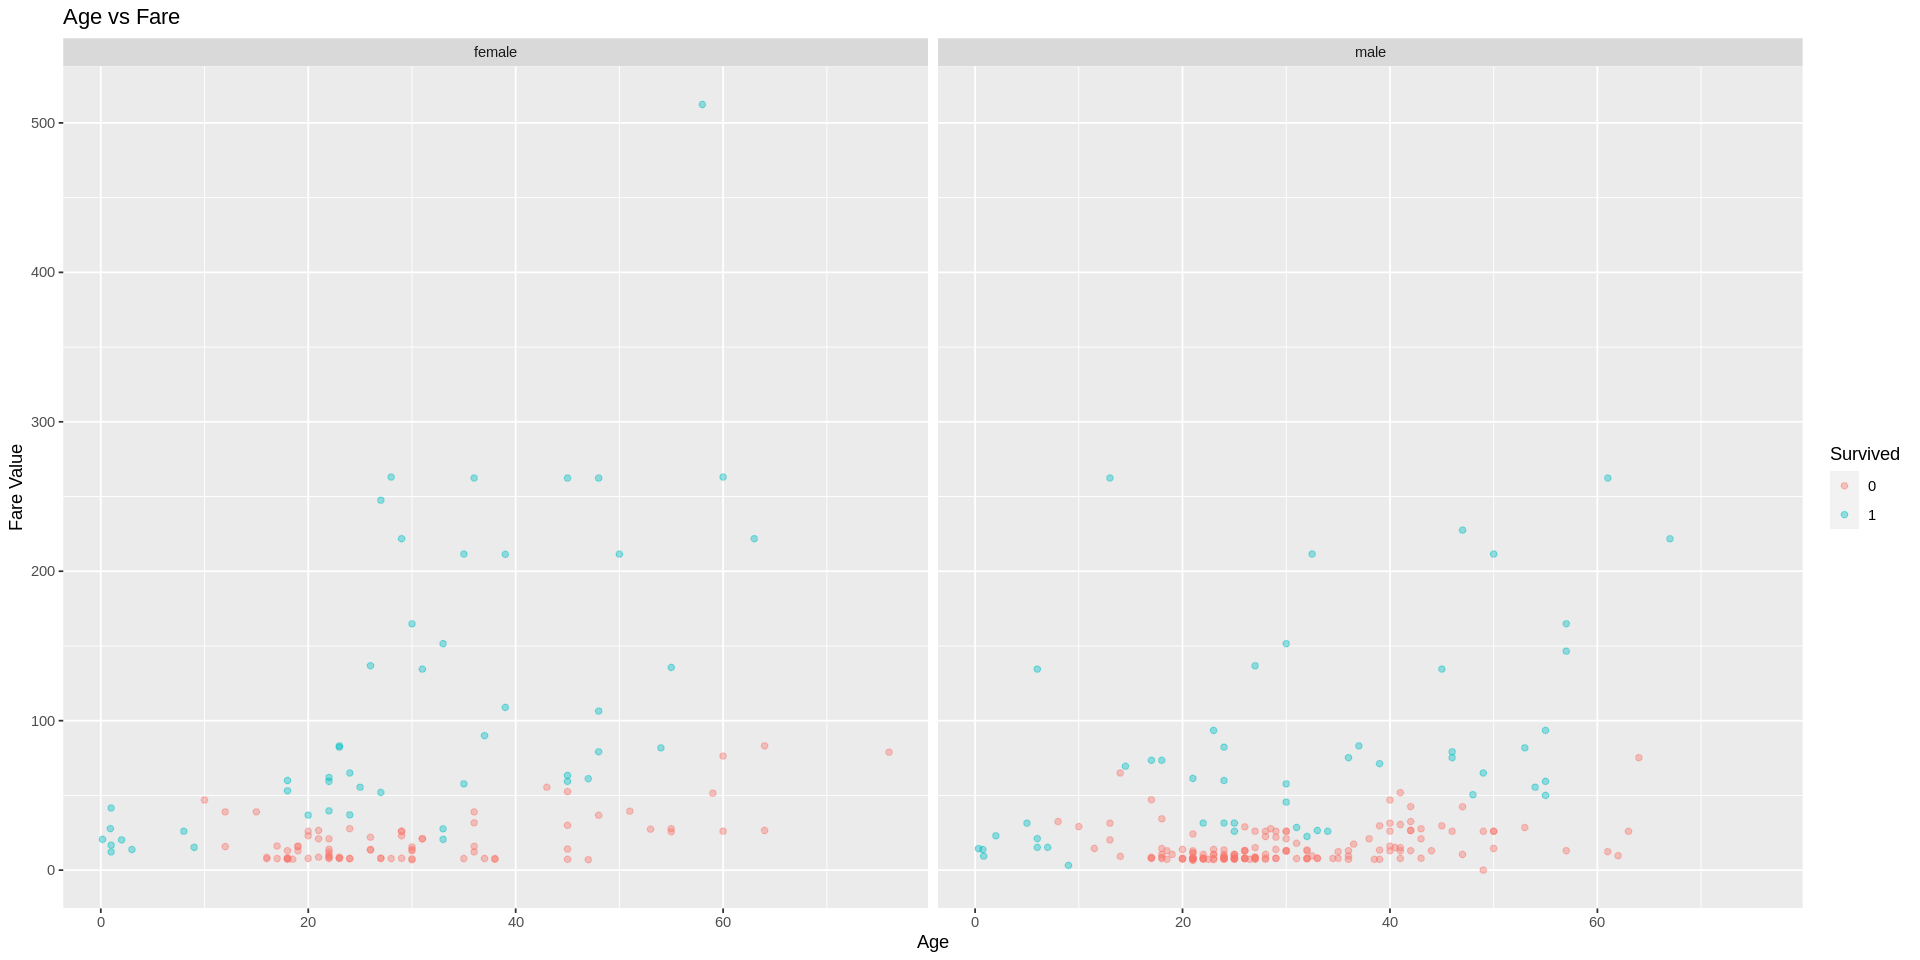

In [6]:
predictions %>% ggplot(aes(x = Age, y =  Fare, colour=.pred_class)) + 
           geom_point(alpha = 0.4) +
          labs(x = "Age", y = "Fare Value", 
             colour = "Survived") +
           ggtitle("Age vs Fare") + facet_grid(. ~ Sex)


**3. Discussion**: 

The original scatter plot made using the original data set, without any further predictions or wrangling, showed that female passengers were predominantly more likely to survive no matter the fare value or age. At the same time, male passengers were less likely to survive as a whole. In the original scatter plot, there was not a strong relationship between Fare Value, Age, Sex, and whether or not the passenger survived. But when we filtered and performed the exploratory data analysis where we did not use Sex as a predictor, the new scatter plot was shown different. The predicted scatter plot showed a clear relationship between fare value and survival. The blue points (survived) are more present in fare values above 50 than the red points (did not survive), meaning that passengers that paid more for their tickets were more likely to survive. There was not as large of a difference between female and male survival due to not using Sex as a predictor and also not a clear relationship / big difference in age affecting survival (except for children under the age of 10). Regarding the accuracy of our classifier, we found that the best K value given a 5-fold cross-validation was 41, with a mean of 68.69% and a standard error of 1.22%. While k = 41 provides the highest level of accuracy of about 69%, k values between 22 to 43 would also be justified. The accuracy and best k-value show that the model will likely be accurate and that our choice of predictors is relatively reasonable to make in this scenario.

The results support the popular notion that the wealthier passengers, who paid higher fare values, were more likely to survive. The explanation would be that the higher the fare, the better located the rooms would be to allow for a faster evacuation; more cynically, the higher classes were prioritized during evacuation as well as during the warnings of the exact scale of the situation. As was also expected, the younger people had higher odds of survival as they were less vulnerable to the cold weather and possibly were able to evacuate the boat after the crash faster. 

The Titanic was a microcosm of society in the past, revealing much about the past's social phenomena and social class issues. Although the social class issue in the Titanic was severe, the social norm of giving priority to women and children was respected. This social norm should be spread since women and children are sustainable resources. This is the reason why even now, the norm of women and children first is still kind of respected. However, this social norm could have slowed down the evacuation on the Titanic, leading to more passengers dying since the exit could have been blocked by the crowd of passengers waiting for their turn, making it nearly impossible for everyone to leave. Hence, organized evacuation and waiting for instructions are necessary. Avoiding traffic during the evacuation helps save more lives. Current airplane evacuations are a good example of a possible impact for the findings from the Titanic. Before takeoff, the safety demonstration and the instruction card in the chair bag let passengers know what to do when an emergency comes. In addition, stewards will conduct and assist passengers to evacuate during the emergency to ensure an orderly evacuation. By understanding the past social circumstances and problems which led to a specific way of managing the crisis, we could learn how not to repeat such a tragedy and let this incident serve as a reminder to future generations that creating social equality will lead to a better future where survival is not dictated by how rich you are.

We investigated how fare and age affects one's survival based on personal factors like social status and when they were born. With further investigation, we could dive deeper into the other factors that affect survival, for instance, within the dataset, the number of siblings, spouses, parents children on board(i.e. direct relatives) might serve as good predictors, limited only by its small range of values, but one could hypothesyse that larger families, in an attempt to save every member, might evacuate more slowly that those travelling alone. Other predictors not present in the dataset could include whether a passenger stayed in a cabin when they were on the cruise. Cabins are cruise ship rooms that usually contain windows. Unlike people with lower cabins such as Second or Third Class, people residing in First Class cabins may have had higher chances to escape when the ship sank through breaking/broken windows. We could replace the variable "gender" with "cabin" to determine whether staying in a cabin would be a good choice for an emergency escape. Lastly, it also can lead us to brainstorm new possible evacuation procedures that increase the survival chances in similar accidents.

**References:** 

Barratt, Nick (2009). Lost Voices From the Titanic: The Defi History. London: Random House. p. 93. ISBN 978-1-84809-151-1.

History.com Editors. “Titanic.” History.com, A&E Television Networks, 9 Nov. 2009, www.history.com/topics/early-20th-century-us/titanic#section_1.

“Titanic - Machine Learning from Disaster.” Kaggle, www.kaggle.com/competitions/titanic/data.

Person. “Titanic Anniversary: Remembering the Third-Class Passengers.” ABC13 Houston, KTRK-TV, 11 Apr. 2021, abc13.com/titanic-anniversary-immigration-world-history/1874040/#:~:text=Approximately 1,317 passengers died when,their area of the Titanic